In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from data_helpers import CDSHelper
from mfe_plots import loadProfileData

==Load data from hdf5 file==

In [3]:
from glob import glob
datafn = glob('h5/gcdata_v3_taxid_*_profile_200_1_stop3utr_0_t22_all.h5')
(xdata, ydata, ydata_nativeonly, ydata_shuffledonly, labels, groups, filesUsed, biasProfiles, dfProfileCorrs, summaryStatistics, wilcoxonDLFEZeroData, wilcoxonDLFE50_100Data, sequenceNativeProfiles, sequenceRandomizedProfiles) = loadProfileData(datafn)

1009370
Loaded 1 profiles (0.54%)
1033802
1033991
1046627
1056495
1072681
1116230
1123384
1129897
Loaded 9 profiles (4.9%)
1142394
1148
115713
1172194
Loaded 13 profiles (7%)
1177928
1189619
1201294
1208660
1209989
1229908
Loaded 19 profiles (10%)
1236689
1236703
1237085
1266370
1266844
1273541
1298851
1303518
Loaded 27 profiles (15%)
1304892
1307761
1313172
1343739
1347342
1379270
Loaded 33 profiles (18%)
1432061
1441628
145458
156889
1574623
Loaded 38 profiles (21%)
1577684
158878
160490
1618331
1618595
1618609
1618643
1618742
1619005
1619029
163003
Loaded 49 profiles (26%)
164328
169963
1737403
176299
178306
186497
187420
188937
190192
Loaded 58 profiles (31%)
192222
195522
196627
203124
203267
Loaded 63 profiles (34%)
208964
223926
224308
224325
227377
228410
Loaded 69 profiles (37%)
228908
235909
240015
Loaded 72 profiles (39%)
243159
243232
243274
251221
257314
262768
266834
267377
267608
267671
Loaded 82 profiles (44%)
272623
272633
272844
273063
273075
283166
288705
28892
28937

0.01652198830749585
-3
minDLFE=-4.012382950741258, pos=-3, native=-8.379879951980792 random=-4.351925450180072 min2=-4.02795450180072
224308
     ProtId  RTSfound  RTSFromPosRelative  RTSToPosRelative  \
0  CAB13374     False                   0                 0   
0  CAB14583     False                   0                 0   
0  CAB11906      True                  -1                47   
0  CAB14398      True                   3                60   
0  CAB14872      True                  -9                52   

   RTSFromPosGenomic  RTSToPosGenomic Strand  NextCDSonOppositeStrand  \
0            1570064          1570133      +                    False   
0            2703090          2703159      -                    False   
0             142363           142432      +                    False   
0            2556077          2556146      -                    False   
0            2978674          2978743      -                    False   

  ChromosomeOrContig                     

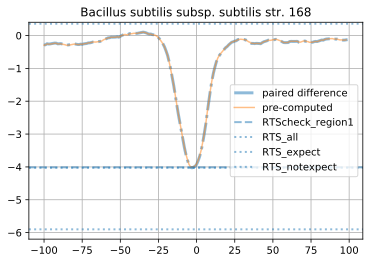

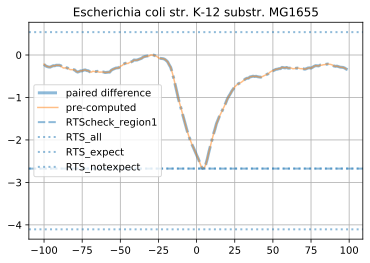

In [78]:
import os.path
from itertools import groupby, accumulate, product
import scipy.stats
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from genome_model import getGenomeModelFromCache
from data_helpers import getSpeciesName
from ncbi_taxa import ncbiTaxa

#
limitToTaxon = 2
RTSallowedRegionStart =  90 #-10
RTSallowedRegionEnd   = 120 #+20
AnalysisWindowCenter  = 100
LFEWindowWidth        =  40
saveSeqs              = True
plotDiagnostics       = False

speciesData = pd.DataFrame( {'TaxId':pd.Series([], dtype='int'),
                             '3UtrLength':     pd.Series([], dtype='float'),
                             'NextOpposite':   pd.Series([], dtype='float'),
                             'GC':             pd.Series([], dtype='float'),
                             'WeakFold':       pd.Series([], dtype='float'),
                             'RTS':            pd.Series([], dtype='float'),
                             'RTS_expect':     pd.Series([], dtype='float'),
                             'RTS_notexpect':  pd.Series([], dtype='float'),
                             'RTSfrac':        pd.Series([], dtype='float'),
                             'RTS_check0':     pd.Series([], dtype='float'),
                             'RTS_check1':     pd.Series([], dtype='float'),
                             'RTS_check2':     pd.Series([], dtype='float'),
                             'GenomeSequence': pd.Series([], dtype='str'),
                             'GenomeAnnot':    pd.Series([], dtype='str'),
                            })
                             #index=pd.Index([], dtype='int'))
figureId = 0
for taxId in biasProfiles.keys(): #[511145]: #
    # Skip unrelated species
    if not limitToTaxon in ncbiTaxa.get_lineage(taxId): continue
    #if not taxId%10 in (3,5,8): continue # DEBUG ONLY
    #if not taxId%10 in (5,): continue # DEBUG ONLY
    #if not taxId in (511145, 224308): continue # DEBUG ONLY
    #if not taxId in (330214,): continue # DEBUG ONLY
    speciesName = getSpeciesName( taxId )

    #-----------------------------------
    # Process each species
    #-----------------------------------
    
    # Find strongest dLFE
    dLFE = biasProfiles[taxId]
    minMeanDLFECheck0 = dLFE[:RTSallowedRegionStart].min()   # access regions by array position (not index)
    minMeanDLFECheck1 = dLFE[RTSallowedRegionStart:RTSallowedRegionEnd].min()
    minMeanDLFECheck2 = dLFE[RTSallowedRegionEnd:].min()    
    maxMeanDLFE       = dLFE.max()
            
    # Process each CDS
    nativeProfiles = sequenceNativeProfiles[taxId]
    randomProfiles = sequenceRandomizedProfiles[taxId]
    allProtIds = sequenceNativeProfiles[taxId].index
    gm = getGenomeModelFromCache(taxId)
    
    # Sanity tests on dLFE profiles
    xx = (nativeProfiles - randomProfiles).mean(axis=0)
    #print(xx.shape[:199])
    #print(dLFE.shape)
    assert(scipy.stats.pearsonr(xx[:199], dLFE)[0] > 0.99)
    print( np.max( np.abs( xx[:199] - dLFE )))
    assert( np.allclose( xx[:199], dLFE, atol=5e-2 ))
    
    # Print statistics on RTS peak
    minDLFE = dLFE[RTSallowedRegionStart:RTSallowedRegionEnd].min()
    minPos = dLFE[RTSallowedRegionStart:RTSallowedRegionEnd].idxmin()
    print(minPos)
    nativeAtPeak = nativeProfiles.loc[:,minPos].mean() # access regions by index
    randomAtPeak = randomProfiles.loc[:,minPos].mean()
    meanMin2 = (nativeProfiles-randomProfiles).loc[:,minPos].mean()
    print("minDLFE={}, pos={}, native={} random={} min2={}".format(minDLFE, minPos, nativeAtPeak, randomAtPeak, meanMin2))
    LFEs = nativeProfiles.mean(axis=0)
    #minLFE = LFEs[LFEs==LFEs.min()]
    #print("minLFE={}".format(minLFE))
    
   
    cdsData = pd.DataFrame( {'ProtId':                  pd.Series([], dtype='str'  ),
                             'RTSfound':                pd.Series([], dtype='bool' ),
                             #'RTSscore':                pd.Series([], dtype='float'),
                             'RTSFromPosRelative':      pd.Series([], dtype='int'  ),
                             'RTSToPosRelative':        pd.Series([], dtype='int'  ),
                             'RTSFromPosGenomic':       pd.Series([], dtype='int'  ),
                             'RTSToPosGenomic':         pd.Series([], dtype='int'  ),
                             'Strand':                  pd.Series([], dtype='str'  ),
                             'NextCDSonOppositeStrand': pd.Series([], dtype='bool' ),
                             'ChromosomeOrContig':      pd.Series([], dtype='str'  ),
                             'RTSRegionSeq':            pd.Series([], dtype='str'  ),
                             'TaxId':                   pd.Series([], dtype='int'  )
                            })
    allLengths    = []
    dLFEall       = []
    dLFEweakRTS   = []
    dLFEstrongRTS = []
    for protId in allProtIds:
        cds = CDSHelper( taxId, protId )
        feature = gm.findFeatureById( protId )
        strand = feature[1].data['strand']  # '+' or '-'
        molecule = gm.moleculeModels[ feature[0] ]
        dlfeProfile = nativeProfiles.loc[protId] - randomProfiles.loc[protId] # dlfe for this protein
        
        # Find mean 3'UTR length
        flanking3UTRLengthNt = cds.flankingRegion3UtrLength()
        allLengths.append( flanking3UTRLengthNt )
        
        nextCDSOnOppositeStrand = cds.nextCDSOnOppositeStrand()
                
        # Save RTS strength
        #minDLFEinRTSregion = dlfeProfile[RTSallowedRegionStart:RTSallowedRegionEnd].min() # access regions by array position (not index)
        minDLFEatPeak = dlfeProfile.loc[minPos]
        #print(minDLFEatPeak)
        dLFEall.append(minDLFEatPeak)
        if flanking3UTRLengthNt >= 25 or nextCDSOnOppositeStrand:
            dLFEstrongRTS.append(minDLFEatPeak)
        else:
            dLFEweakRTS.append(minDLFEatPeak)        

        # Find longest strectch of positions with negative dLFE
        cands =  [(x,len(tuple(y))) for x,y in groupby(dlfeProfile[RTSallowedRegionStart:RTSallowedRegionEnd] < 0.0)]
        starts = (0,) + tuple(accumulate([x[1] for x in cands]))
        ds =     [x for x in list(zip(cands, starts)) if x[0][0]]
        ds =     sorted(ds, key=lambda x:x[0][1], reverse=True)
        RTSfound        = False
        RTSfromRelative = 0
        RTStoRelative   = 0
        
        if ds:
            RTSlength = ds[0][0][1]  # length of longest stretch found
            if (RTSlength > 4) and (flanking3UTRLengthNt >= 25 or nextCDSOnOppositeStrand): # RTS criterion
                RTSfound = True
                RTSfromRelative = ds[0][1] + RTSallowedRegionStart - AnalysisWindowCenter
                RTStoRelative   = RTSfromRelative + RTSlength + LFEWindowWidth

        # DEBUG ONLY ###  DEBUG ONLY ###  DEBUG ONLY ###  DEBUG ONLY ###  DEBUG ONLY #
        #RTSfromRelative = -3
        #RTStoRelative   =  3
        # DEBUG ONLY ###  DEBUG ONLY ###  DEBUG ONLY ###  DEBUG ONLY ###  DEBUG ONLY #
        
        # Extract sequence for RTS, or for the RTS allowed region (when no RTS is found)
        absoluteStart = 0
        absoluteEnd   = 0
        rtsSeq        = ''
        if RTSfound:
            if strand=='+':
                absoluteStart = feature[1].end   + RTSfromRelative                   - 3
                absoluteEnd   = feature[1].end   + RTStoRelative   + LFEWindowWidth  + 3 - 1
                # Ignore RTS and save the entire region
                #absoluteStart = feature[1].end   + RTSallowedRegionStart - AnalysisWindowCenter                
                #absoluteEnd   = feature[1].end   + RTSallowedRegionEnd   - AnalysisWindowCenter + LFEWindowWidth - 1
                if saveSeqs:
                    rtsSeq = molecule.getSequence(
                        absoluteStart,
                        absoluteEnd,
                        rc=False)
                    rtsSeq = str(rtsSeq)
            else:
                absoluteStart = feature[1].begin - RTStoRelative  - LFEWindowWidth - 3
                absoluteEnd   = feature[1].begin - RTSfromRelative                 + 3
                # Ignore RTS and save the entire region
                #absoluteStart = feature[1].begin - (RTSallowedRegionEnd   - AnalysisWindowCenter) - LFEWindowWidth
                #absoluteEnd   = feature[1].begin - (RTSallowedRegionStart - AnalysisWindowCenter)- 1
                if saveSeqs:
                    rtsSeq = molecule.getSequence(
                        absoluteStart,
                        absoluteEnd,
                        rc=True)
                    rtsSeq = str(rtsSeq)
        else:
            if strand=='+':
                absoluteStart = feature[1].end   + RTSallowedRegionStart - AnalysisWindowCenter                
                absoluteEnd   = feature[1].end   + RTSallowedRegionEnd   - AnalysisWindowCenter + LFEWindowWidth - 1
                if saveSeqs:
                    rtsSeq = molecule.getSequence(
                        absoluteStart,
                        absoluteEnd,
                        rc=False)
                    rtsSeq = str(rtsSeq)
            else:
                absoluteStart = feature[1].begin - (RTSallowedRegionEnd   - AnalysisWindowCenter) - LFEWindowWidth
                absoluteEnd   = feature[1].begin   - (RTSallowedRegionStart - AnalysisWindowCenter)- 1
                if saveSeqs:
                    rtsSeq = molecule.getSequence(
                        absoluteStart,
                        absoluteEnd,
                        rc=True)
                    rtsSeq = str(rtsSeq)

        if not saveSeqs:
            rtsSeq = ''
                        
        cdsData = cdsData.append( pd.DataFrame({
            'ProtId':                  pd.Series([protId],              dtype='str'  ),
            'RTSfound':                pd.Series([RTSfound],            dtype='bool' ),
        #    'RTSscore':                pd.Series([0.0],                 dtype='float'),
            'RTSFromPosRelative':      pd.Series([RTSfromRelative],     dtype='int'  ),
            'RTSToPosRelative':        pd.Series([RTStoRelative],       dtype='int'  ),
            'RTSFromPosGenomic':       pd.Series([absoluteStart],       dtype='int'  ),
            'RTSToPosGenomic':         pd.Series([absoluteEnd  ],       dtype='int'  ),
            'Strand':                  pd.Series([strand],              dtype='str'  ),
            'NextCDSonOppositeStrand': pd.Series([nextCDSOnOppositeStrand], dtype='bool'),
            'ChromosomeOrContig':      pd.Series([molecule.name],       dtype='str'  ),
            'RTSRegionSeq':            pd.Series([rtsSeq],              dtype='str'  ),
            'TaxId':                   pd.Series([taxId],               dtype='int'  )
            }))
    
    print(taxId)
    print(cdsData.head())
    print(cdsData.shape)
    cdsData.to_csv("rts_export_taxid_{}.csv".format(taxId), sep=',')

    if saveSeqs:
        for strandChoice, RTSChoice in product( ('+','-'), (True, False) ):
            seqsToSave = cdsData.loc[ np.logical_and( cdsData['Strand'  ]==strandChoice,
                                                      cdsData['RTSfound']==RTSChoice     ),
                                      ('ProtId', 'RTSRegionSeq', 'ChromosomeOrContig', 'RTSFromPosGenomic', 'RTSToPosGenomic') ]
            recs = []
            for row in seqsToSave.itertuples():
                recs.append( SeqRecord( Seq( row.RTSRegionSeq,
                                            IUPAC.unambiguous_dna),
                                       id=row.ProtId,
                                       description='{}_{}_{}'.format(row.ChromosomeOrContig, row.RTSFromPosGenomic, row.RTSToPosGenomic)) )

            SeqIO.write(recs, "rts_export_taxid_{}_strand_{}_rts_{}_x.fna".format(taxId, 
                                                                                'pos' if strandChoice=='+' else 'neg', 
                                                                                RTSChoice), "fasta")
        
    meanLength = np.mean(allLengths)
    
    nextCDSoppositeStrandCountTrue  = sum(cdsData['NextCDSonOppositeStrand']==True)
    nextCDSoppositeStrandCountFalse = sum(cdsData['NextCDSonOppositeStrand']==False)
    nextCDSoppositeStrandFrac = nextCDSoppositeStrandCountTrue / (nextCDSoppositeStrandCountFalse+nextCDSoppositeStrandCountTrue)
    
    RTSfoundCount    = sum(cdsData['RTSfound']==True)
    RTSnotFoundCount = sum(cdsData['RTSfound']==False)
    RTSfraction = RTSfoundCount / (RTSfoundCount+RTSnotFoundCount)
    
    
    sequenceFile = os.path.basename( gm.sequenceFile )
    gffFile      = os.path.basename( gm.gffFile )
    
    if plotDiagnostics:
        plt.figure(figureId)
        plt.plot( xx.index,   xx,   alpha=0.5,  ls='-.', lw=3,             label='paired difference' )
        plt.plot( dLFE.index, dLFE, alpha=0.5,           lw=1.5,           label='pre-computed' )
        plt.axhline( y=minMeanDLFECheck1,        alpha=0.5, ls='--', lw=2, label='RTScheck_region1' )
        plt.axhline( y=np.array(dLFEall).mean(), alpha=0.5, ls=':',  lw=2, label='RTS_all' )
        plt.axhline( y=np.array(dLFEstrongRTS).mean(), alpha=0.5, ls=':',  lw=2, label='RTS_expect' )
        plt.axhline( y=np.array(dLFEweakRTS).mean(),   alpha=0.5, ls=':',  lw=2, label='RTS_notexpect' )
        plt.title( speciesName )
        plt.grid()
        plt.legend()
        figureId += 1

    
    gcCount = 0
    allBasesCount = 0
    for molecule in gm.moleculeModels:
        seq = molecule.getSequence(1, 100000000).seq.lower()
        gcCount       += sum([x in 'cg'   for x in seq])
        allBasesCount += sum([x in 'acgt' for x in seq]) # careful not to count Ns in either group
    GC = gcCount / allBasesCount
    
    # Save all params
    rec = pd.DataFrame( {'TaxId':          pd.Series([taxId        ],     dtype='int'  ),
                         '3UtrLength':     pd.Series([meanLength   ],     dtype='float'),
                         'NextOpposite':   pd.Series([nextCDSoppositeStrandFrac],                    dtype='float'),
                         'GC':             pd.Series([GC           ],     dtype='float'),
                         'WeakFold':       pd.Series([maxMeanDLFE  ],     dtype='float'),
                         'RTS':            pd.Series([np.array(dLFEall).mean()  ], dtype='float'),
                         'RTS_expect':     pd.Series([np.array(dLFEstrongRTS).mean()],               dtype='float'),
                         'RTS_notexpect':  pd.Series([np.array(dLFEweakRTS).mean()  ],               dtype='float'),
                         'RTSfrac':        pd.Series([RTSfraction  ],     dtype='float'),
                         'RTS_check0':     pd.Series([minMeanDLFECheck0], dtype='float'),
                         'RTS_check1':     pd.Series([minMeanDLFECheck1], dtype='float'),
                         'RTS_check2':     pd.Series([minMeanDLFECheck2], dtype='float'),
                         'GenomeSequence': pd.Series([sequenceFile ],     dtype='str'  ),
                         'GenomeAnnot':    pd.Series([gffFile      ],     dtype='str'  )
                        })
                         #index=pd.Index([taxId]))
    speciesData = speciesData.append(rec)

speciesData.to_csv("rts_export_bacteria.csv", sep=',')
print(speciesData)

In [10]:
speciesData.to_csv("rts_export_bacteria.csv", sep=',')


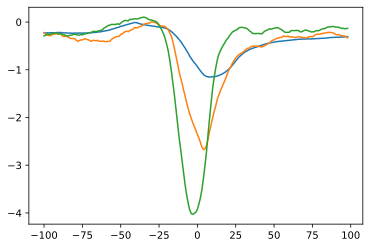

In [90]:
# Save profile data to csv files
allBacteria = []
for taxId in biasProfiles.keys(): #[511145]: #
    # Skip unrelated species
    if not limitToTaxon in ncbiTaxa.get_lineage(taxId): continue
    allBacteria.append(taxId)

positions = list(map(int, biasProfiles[511145].index.values))

nativeLFEdata = pd.DataFrame( dict(zip( positions, [0.0]*len(positions))), index=pd.Index(allBacteria))
deltaLFEdata  = pd.DataFrame( dict(zip( positions, [0.0]*len(positions))), index=pd.Index(allBacteria))
#nativeLFEdata.loc[937777,-99] = 5.0
#nativeLFEdata.loc[1033802,-94] = 3.3

for taxId in allBacteria: #[511145]: #
    nativeLFE = sequenceNativeProfiles[taxId].mean(axis=0)
    
    deltaLFE  = (sequenceNativeProfiles[taxId] - sequenceRandomizedProfiles[taxId]).mean(axis=0)
    for pos in positions:
        nativeLFEdata.loc[taxId,pos] = nativeLFE.loc[pos]
        deltaLFEdata.loc[taxId,pos]  = deltaLFE.loc[pos]

#plt.plot( positions, nativeLFEdata)
#plt.plot( positions, nativeLFEdata.mean(axis=0))
plt.plot( positions, deltaLFEdata.mean(axis=0))
plt.plot( positions, deltaLFEdata.loc[511145,:])
plt.plot( positions, deltaLFEdata.loc[224308,:])

deltaLFEdata.to_csv("rts_export_delta_LFE.csv",   sep=',')
nativeLFEdata.to_csv("rts_export_native_LFE.csv", sep=',')

In [125]:
# Count start codons occurences in the overlapping triplets within 3'-UTRs

startCodons = ('ATG','GTG', 'TTG')

def utr3SequencesSource(taxId, utrWidth=50, includeStop=False):
    allProtIds = sequenceNativeProfiles[taxId].index
    
    gm = getGenomeModelFromCache(taxId)    
    
    for protId in allProtIds:
        cds = CDSHelper( taxId, protId )
        feature = gm.findFeatureById( protId )
        strand = feature[1].data['strand']  # '+' or '-'
        molecule = gm.moleculeModels[ feature[0] ]
        
        stopCodonOffset = 3 if includeStop else 0
        
        if strand=='+':
            absoluteStart = feature[1].end   + 0        - stopCodonOffset
            absoluteEnd   = feature[1].end   + utrWidth - 1
            
            utrSeq = molecule.getSequence(
                absoluteStart,
                absoluteEnd,
                rc=False)
            utrSeq = str(utrSeq)
        else:
            absoluteStart = feature[1].begin  - utrWidth
            absoluteEnd   = feature[1].begin  -        0 - 1   + stopCodonOffset
            
            utrSeq = molecule.getSequence(
                absoluteStart,
                absoluteEnd,
                rc=True)
            utrSeq = str(utrSeq)
            
        yield (utrSeq, protId)

def saveToFasta(seqs, fn, alphabet=IUPAC.unambiguous_dna):
    recs = []
    for seq, protId in seqs:
        recs.append( SeqRecord( Seq( seq,
                                     alphabet),
                               id=protId,
                               description='') )

    SeqIO.write(recs, fn, "fasta")
    
def getCodonsAll3Frames(seq):
    for i in range(len(seq)-2):
        yield seq[i:i+3]
        
#print(list(getCodonsAll3Frames("1234567890")))
#print(list(getCodonsAll3Frames("1234")))
#print(list(getCodonsAll3Frames("123")))
    
for taxId in biasProfiles.keys(): #[511145]: #
    # Skip unrelated species
    if not limitToTaxon in ncbiTaxa.get_lineage(taxId): continue
    #if not taxId%10 in (3,5,8): continue # DEBUG ONLY
    #if not taxId%10 in (5,): continue # DEBUG ONLY
    if not taxId in (511145, 224308): continue # DEBUG ONLY
    #if not taxId in (330214,): continue # DEBUG ONLY
    speciesName = getSpeciesName( taxId )
    
    seqs = []
    
    specialCodonCounts = dict( zip( startCodons, [0]*len(startCodons) ) )
    specialCodonCounts['*any*'] = 0
    allCodonsCount = 0
    sequenceStats = {False: 0, True:0}
    countsPerSeq = []
    
    for utr, protId in utr3SequencesSource(taxId, utrWidth=50, includeStop=False):
        seqs.append((utr, protId))  # save seqs (for debug purposes)
        
        allOverlappingCodons = list(getCodonsAll3Frames( utr ))
        allCodonsCount += len(allOverlappingCodons)
        
        thisSequenceStatus = False
        startCodonCounts   = 0

        for codon in startCodons:
            for c in allOverlappingCodons:
                if c==codon:
                    # Match found - update statistics
                    specialCodonCounts[codon]   += 1
                    specialCodonCounts['*any*'] += 1
                    thisSequenceStatus = True
                    startCodonCounts += 1
                    
        countsPerSeq.append( startCodonCounts )
        
        sequenceStats[thisSequenceStatus] += 1
                
    averageNumberOfStartCodonOccurences = np.array(countsPerSeq).mean()
    
    print('{} -> Start codon counts: {} All codon counts: {}: Has any start codons: {} Average start codons per seq: {:.4}'.format(speciesName, specialCodonCounts, allCodonsCount, sequenceStats, averageNumberOfStartCodonOccurences))
    
    saveToFasta( seqs, 'rts_utrseqs_debug_taxid_{}.fna'.format(taxId) )


Bacillus subtilis subsp. subtilis str. 168 -> Start codon counts: {'ATG': 4176, 'GTG': 2079, 'TTG': 3924, '*any*': 10179} All codon counts: 199920: Has any start codons: {False: 308, True: 3857} Average start codons per seq: 2.444
Escherichia coli str. K-12 substr. MG1655 -> Start codon counts: {'ATG': 3343, 'GTG': 2180, 'TTG': 3226, '*any*': 8749} All codon counts: 197664: Has any start codons: {False: 512, True: 3606} Average start codons per seq: 2.125


In [ ]:
!host